In [1]:
import glob
import os

import GPRutils
import vK2KGPR
import plotGPR

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import astropy.stats as stats
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
files = glob.glob(f"../thesis/??????")
bandDict = {"r": 0, "i": 1, "z": 2}

corr = {}
nG = 0
for file in files:
    try:
        exp = os.path.basename(file)
        dC = GPRutils.loadNPZ(os.path.join(file, exp+".npz"))
    except FileNotFoundError:
        continue
        
    X = dC.Xvalid
    Y = dC.Yvalid
    Y2 = dC.Yvalid - dC.fbar_s
    
    x, y = dC.Xvalid.T*u.deg
    dx, dy = dC.Yvalid.T*u.mas
    dx2, dy2 = (dC.Yvalid.T - dC.fbar_s.T)*u.mas
    
    # Find exposure band
    with open(f"../thesis/{exp}/out.out", "r") as f:
        paramLines = f.readlines()
    band = paramLines[1][8]
    if band == "g":
        nG += 1
        print(exp)
        continue

    corr[exp] = []
    
    # Find star density
    nTrain = dC.Xtrain.shape[0]
    nValid = dC.Xvalid.shape[0]
    starDensity = (nTrain + nValid) / (3*u.deg**2).to(u.arcmin**2).value
    
    # Find xi_{0.02} of raw data
    xi_raw, Uerr_raw, Verr_raw, _ = GPRutils.getXi(X, Y)
    err_raw = np.sqrt(Uerr_raw**2 + Verr_raw**2)
    
    # Find xi_{0.02} of GPR model subtracted data
    xi_GPR, Uerr_GPR, Verr_GPR, _ = GPRutils.getXi(X, Y2)
    err_GPR = np.sqrt(Uerr_GPR**2 + Verr_GPR**2)
    
    # Find xi_+(r) for raw data
    result = GPRutils.calcCorrelation(x, y, dx, dy)
    xiplus_raw = result[1]
    
    # Find xi_+(r) for GPR model subtracted data
    result = GPRutils.calcCorrelation(x, y, dx2, dy2)
    xiplus_GPR = result[1]
    
    r = np.exp(result[0])
    
    xi_raw_001, _, _, _ = GPRutils.getXi(X, Y, rMax=0.01*u.deg)
    xi_GPR_001, _, _, _ = GPRutils.getXi(X, Y2, rMax=0.01*u.deg)
    
    corr[exp].extend([
        bandDict[band], starDensity,
        xi_raw, err_raw, xi_raw_001, xiplus_raw,
        xi_GPR, err_GPR, xi_GPR_001, xiplus_GPR,
    ])

/home/fortino/DESworkspace/GPRutils.py:995: RuntimeWarning: invalid value encountered in true_divide
  logr /= counts
/home/fortino/DESworkspace/GPRutils.py:1001: RuntimeWarning: invalid value encountered in true_divide
  xiplus /= counts
/home/fortino/DESworkspace/GPRutils.py:1006: RuntimeWarning: invalid value encountered in true_divide
  xiz2 /= counts
/home/fortino/DESworkspace/GPRutils.py:1015: RuntimeWarning: invalid value encountered in true_divide
  ximinus /= counts


474262
361580
474265
696547
484483
367484
369801
576863
791229
791593
791640
579816


In [3]:
data = np.array(list(corr.values()))

In [4]:
arr_band = data[:, 0].astype(int)
arr_starDensities = data[:, 1]

arr_xi_raw = data[:, 2]
arr_err_raw = data[:, 3]
arr_001_raw = data[:, 4]
arr_xiplus_raw = np.stack(data[:, 5])

arr_xi_GPR = data[:, 6]
arr_err_GPR = data[:, 7]
arr_001_GPR = data[:, 8]
arr_xiplus_GPR = np.stack(data[:, 9])

In [5]:
# Number of exposures
data.shape[0], nG, nG + data.shape[0], len(files)

(52, 12, 64, 69)

In [6]:
# Mean star density
np.mean(arr_starDensities)

0.980571581196581

In [7]:
# Median xi_{0.02}
np.median(arr_xi_raw), np.median(arr_xi_GPR), np.median(arr_xi_raw/arr_xi_GPR), np.median((arr_xi_GPR - arr_xi_raw)/arr_xi_raw)

(86.94083345770977, 7.552045087578852, 11.81454954547851, -0.9153568621224907)

In [8]:
# Median xi_{0.01}
np.median(arr_001_raw), np.median(arr_001_GPR), np.median(arr_001_raw/arr_001_GPR), np.median((arr_001_GPR - arr_001_raw)/arr_001_raw)

(90.11000193415629, 11.261339623101506, 8.520325818008027, -0.8825952739287544)

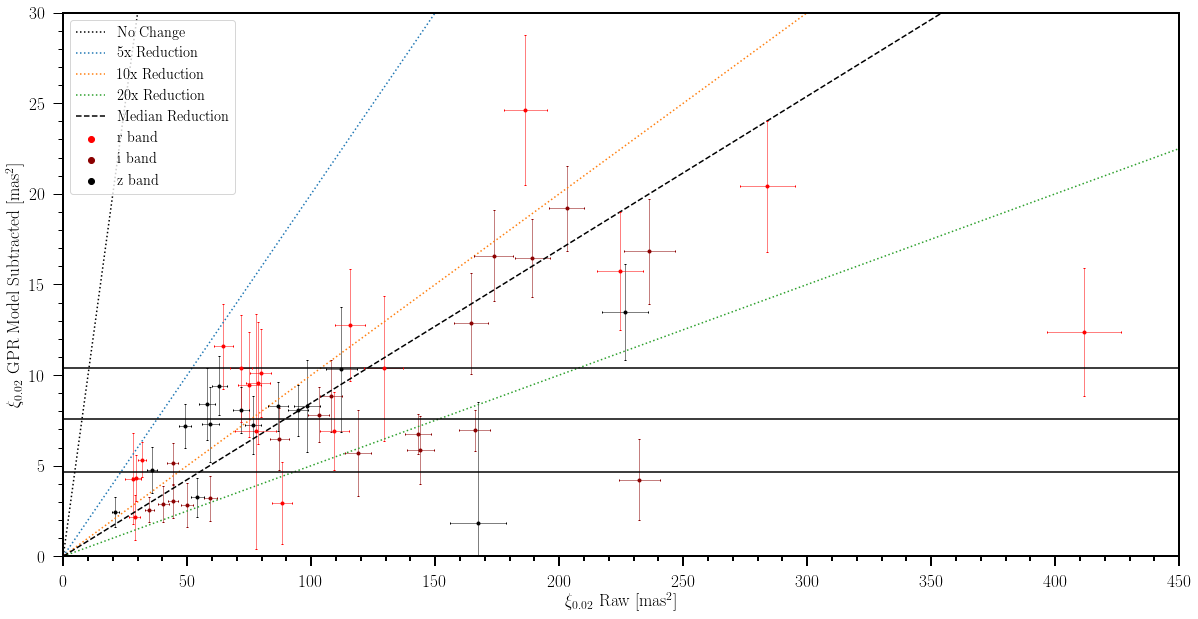

In [9]:
plt.figure(figsize=(20, 10))

plt.scatter(-1, 0, alpha=1, color="red", label="r band")
plt.scatter(-1, 0, alpha=1, color="darkred", label="i band")
plt.scatter(-1, 0, alpha=1, color="black", label="z band")

x = np.linspace(0, 500, 2)
plt.plot(x, x, "k:", label="No Change")
plt.plot(x, x/5, c="tab:blue", ls=":", label="5x Reduction")
plt.plot(x, x/10, c="tab:orange", ls=":", label="10x Reduction")
plt.plot(x, x/20, c="tab:green", ls=":", label="20x Reduction")
plt.plot(x, x/np.median(arr_xi_raw/arr_xi_GPR), c="black", ls="--", label="Median Reduction")

percs = np.percentile(arr_xi_GPR, (25, 50, 75))
plt.axhline(y=percs[0])
plt.axhline(y=percs[1])
plt.axhline(y=percs[2])

for exp in corr.keys():
    
    if corr[exp][0] == 0: c = "red"
    elif corr[exp][0] == 1: c = "darkred"
    elif corr[exp][0] == 2: c = "black"
    else: print(corr[exp][0])
    
    plt.errorbar(
        corr[exp][2], corr[exp][6],
        xerr=corr[exp][3], yerr=corr[exp][7],
        color=c, marker=".",
        linewidth=0.5, capsize=1)


plt.ylim((0, 30))
plt.xlim((0, 450))
plt.xlabel(r"$\xi_{0.02}$ Raw [mas$^2$]")
plt.ylabel(r"$\xi_{0.02}$ GPR Model Subtracted [mas$^2$]")
plt.legend(loc="upper left")

plt.savefig("thesis_plots/xiBA.pdf")
plt.show()

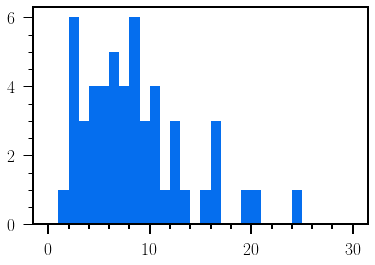

In [10]:
plt.hist(arr_xi_GPR, range=(0, 30), bins=30)
plt.show()

In [11]:
xiplus_raw = np.nanmean(arr_xiplus_raw, axis=0)
xiplus_GPR = np.nanmean(arr_xiplus_GPR, axis=0)
xi_raw = np.nanmean(arr_001_raw)
xi_GPR = np.nanmean(arr_001_GPR)

r0_raw = r[np.abs(xiplus_raw - xi_raw/2).argmin()]
r0_GPR = r[np.abs(xiplus_GPR - xi_GPR/2).argmin()]
(r0_raw*u.deg).to(u.arcmin), (r0_GPR*u.deg).to(u.arcmin), (r0_GPR - r0_raw)/r0_raw

(<Quantity 5.42270137 arcmin>,
 <Quantity 0.73531559 arcmin>,
 -0.8644005001970637)

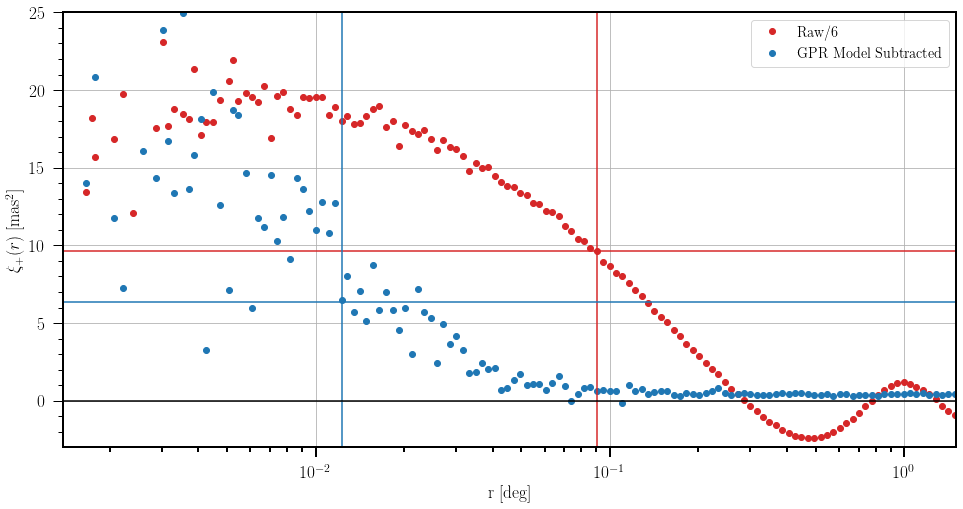

In [12]:
fig = plt.figure(figsize=(16, 8))

plt.semilogx(r, np.nanmean(arr_xiplus_raw, axis=0)/6, color="tab:red", marker="o", ls="", label="Raw/6")
plt.semilogx(r, np.nanmean(arr_xiplus_GPR, axis=0), color="tab:blue", marker="o",  ls="", label="GPR Model Subtracted")


plt.axhline(y=xi_raw/2/6, c="tab:red")
plt.axvline(x=r0_raw, c="tab:red")

plt.axhline(y=xi_GPR/2, c="tab:blue")
plt.axvline(x=r0_GPR, c="tab:blue")

plt.xlabel("r [deg]")
plt.ylabel(r"$\xi_+(r)$ [mas$^2$]")

plt.axhline(y=0)
plt.xlim(((5*u.arcsec).to(u.deg).value, (1.5*u.deg).to(u.deg).value))
plt.ylim((-3, 25))

plt.grid()
plt.legend()

plt.savefig("thesis_plots/avgxi.pdf")
plt.show()

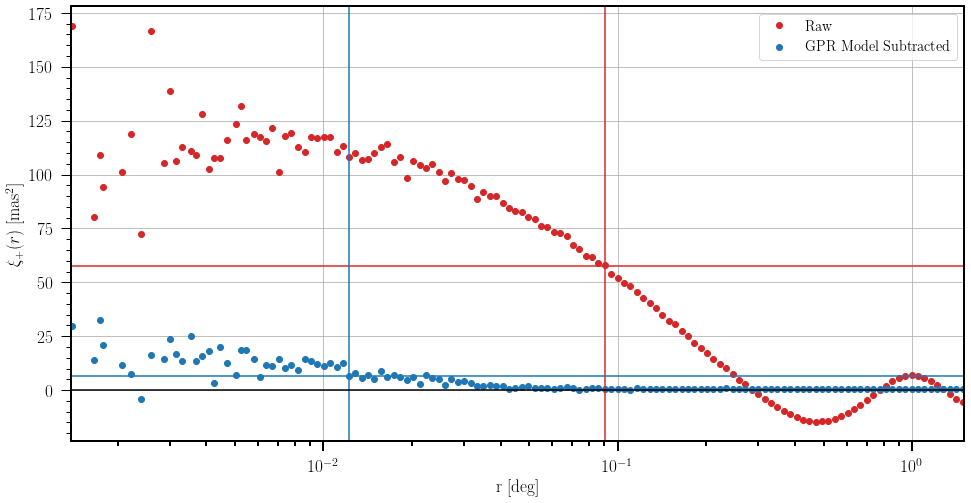

In [13]:
fig = plt.figure(figsize=(16, 8))

plt.semilogx(r, np.nanmean(arr_xiplus_raw, axis=0), color="tab:red", marker="o", ls="", label="Raw")
plt.semilogx(r, np.nanmean(arr_xiplus_GPR, axis=0), color="tab:blue", marker="o",  ls="", label="GPR Model Subtracted")


plt.axhline(y=xi_raw/2, c="tab:red")
plt.axvline(x=r0_raw, c="tab:red")

plt.axhline(y=xi_GPR/2, c="tab:blue")
plt.axvline(x=r0_GPR, c="tab:blue")

plt.xlabel("r [deg]")
plt.ylabel(r"$\xi_+(r)$ [mas$^2$]")

plt.axhline(y=0)
plt.xlim(((5*u.arcsec).to(u.deg).value, (1.5*u.deg).to(u.deg).value))
# plt.ylim((-3, 150))

plt.grid()
plt.legend()

# plt.savefig("thesis_plots/avgxi.pdf")
plt.show()